In [ ]:
import pandas as pd
import numpy as np
import logging
import tensorflow as tf
import warnings
from glob import glob
import tqdm
import cv2
import os
import matplotlib.pyplot as plt

In [ ]:
from tqdm import tqdm 
from IPython import display 
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap
from keras.utils.vis_utils import plot_model

In [ ]:
import glob

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# convolution layers & core layers
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Lambda, MaxPooling2D, Dense, Dropout, Flatten 

In [ ]:
from tensorflow import keras

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras_preprocessing.image import load_img, img_to_array
from keras.callbacks import EarlyStopping, ModelCheckpoint, History
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization

In [ ]:
# vgg16
from keras.applications.vgg16 import VGG16

In [ ]:
# Inception V3
from keras.applications.inception_v3 import InceptionV3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Resnet
from tf.keras.applications.resnet50 import ResNet50

In [ ]:
# Directory paths for importing data

train_path = "/content/drive/MyDrive/Deep_Learning/Mini_Project_CT1/Project/TRAIN/"
test_path = "/content/drive/MyDrive/Deep_Learning/Mini_Project_CT1/Project/TEST/"

In [ ]:
x_data = []
y_data = []

In [ ]:
for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 5799/5799 [01:32<00:00, 62.59it/s] 


In [ ]:
# Os path join (train)

train_o = glob.glob(os.path.join(train_path, 'O', '*.jpg'))
train_r = glob.glob(os.path.join(test_path, 'R', '*.jpg'))

a = len(train_o)
b = len(train_r)

print("Number of training samples: {}".format(a+b))

Number of training samples: 9605


Data Augumentation

In [ ]:
# Datagenerators

train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

Train Datasets

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size= (224,224),
        batch_size = 32,
        color_mode= "rgb",
        class_mode= "categorical")

Found 14292 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_path, 
        target_size= (224,224),
        batch_size = 32,
        color_mode= "rgb",
        class_mode= "categorical")

Found 2482 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)
print(test_generator.class_indices)

{'O': 0, 'R': 1}
{'O': 0, 'R': 1}


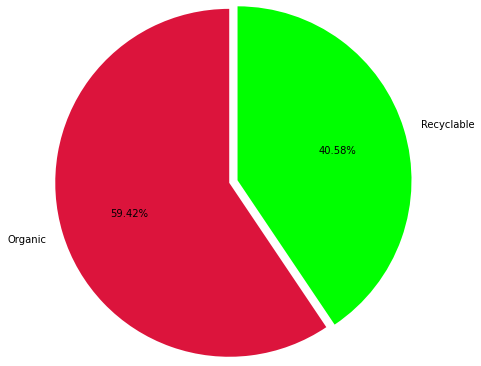

In [ ]:
colors = ['#DC143C','#00FF00']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors= colors,radius=2)
plt.show()

In [ ]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


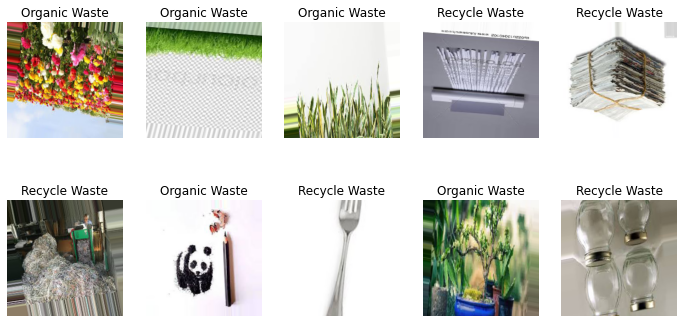

In [ ]:
# Viewing images

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (12,6))
#plt.subplots_adjust(hspace=0.55)

for i in range(2):
    for j in range(5):
        rand1 = np.random.randint(len(train_generator))
        rand2 = np.random.randint(32)
        ax[i,j].imshow(train_generator[rand1][0][rand2])
        ax[i,j].axis('off')
        label = train_generator[rand1][1][rand2]
        # print(label[0])
        if label[0] == 0:
            ax[i,j].set_title('Recycle Waste')
        else:
            ax[i,j].set_title('Organic Waste')

plt.tight_layout
plt.show()

Building Model

In [ ]:
# Defining callbacks

filepath = './final_model_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

Base Model (VGG16)

In [ ]:
# Base model

base_model = VGG16(input_shape=(32,32,3), 
                   include_top=False,
                   weights="imagenet")

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# Freezing layers 

for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Show vgg model summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

ResNet50

In [ ]:
resnet_model = ResNet50(weights= 'imagenet',
                        include_top=False, 
                        input_shape= (32,32,3))

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
# Freezing layers 

for layer in resnet_model.layers:
    layer.trainable=False

In [ ]:
# Show ResNet50 model summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Building Convolutional Neural Network

In [ ]:
model = Sequential()

model.add(Conv2D(32,(3,3),input_shape = (32,32,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))  
model.add(Activation("relu"))
model.add(MaxPooling2D())


model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass)) # output
model.add(Activation("sigmoid"))


batch_size = 256

In [ ]:
# Model fit (training)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.AUC(name = 'auc')])
model_history = model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks = callback_list, verbose = 1)

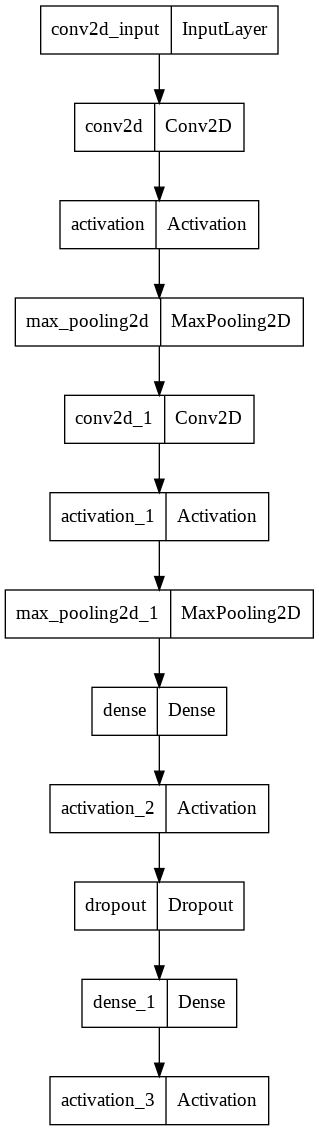

In [ ]:
plot_model(model)

In [ ]:
train_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
test_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 14292 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 2482 images belonging to 2 classes.


block1_conv1
64


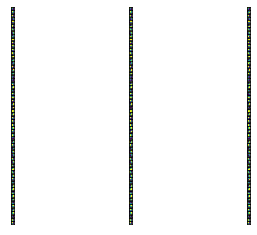

block1_conv2
64


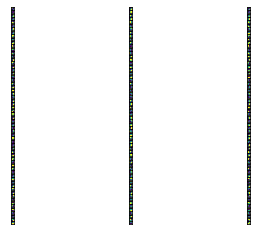

block2_conv1
128


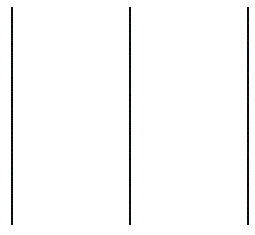

block2_conv2
128


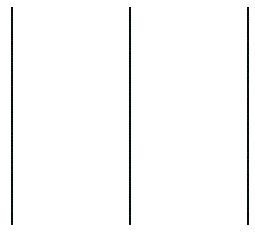

block3_conv1
256


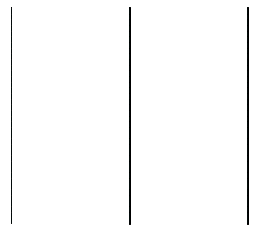

block3_conv2
256


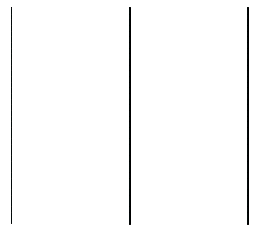

block3_conv3
256


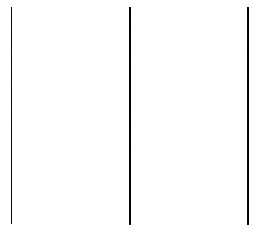

block4_conv1
512


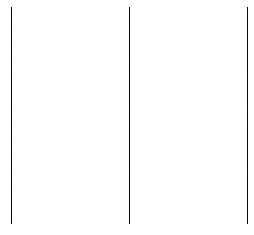

block4_conv2
512


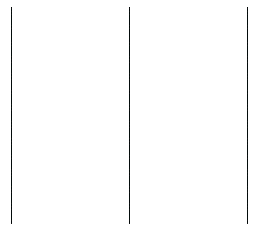

block4_conv3
512


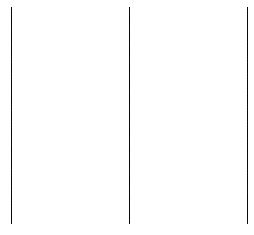

block5_conv1
512


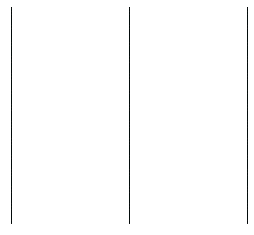

block5_conv2
512


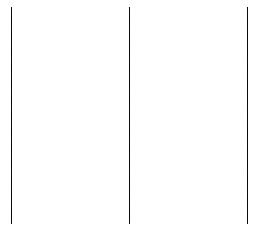

block5_conv3
512


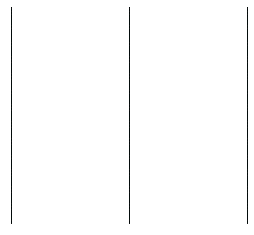

In [ ]:
# Iterate thru all the layers of the model

for layer in base_model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        # filters, biases = layer.get_weights()
        print(layer.name)
        # print(layer.name, filters.shape)
        # normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        # plotting all the filters
        for i in range(filters.shape[3]):
            # get the filters
            filt=filters[:,:,:, i]
            # plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax = plt.subplot(filters.shape[3], filters.shape[0], filter_cnt)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()